# Library Loading

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
data = pd.read_csv('../data/train_qso_wo_image.csv')
df_test = pd.read_csv('../data/train_qso_wo_image.csv')

# Data Processing

## Scaling

In [61]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler()
s.fit(data[['ug', 'ur', 'ui', 'uz', 'uj', 'uk', 'uw1', 'uw2', 'gr',
       'gi', 'gz', 'gk', 'gw1', 'gw2', 'ri', 'rz', 'rw1', 'rw2', 'iz', 'ij',
       'ik', 'iw1', 'iw2', 'zj', 'zk', 'zw1', 'zw2', 'jw1', 'jw2', 'kw1',
       'kw2', 'w1w2', 'petroR50_g', 'petroR50_r']])
data[['ug', 'ur', 'ui', 'uz', 'uj', 'uk', 'uw1', 'uw2', 'gr',
       'gi', 'gz', 'gk', 'gw1', 'gw2', 'ri', 'rz', 'rw1', 'rw2', 'iz', 'ij',
       'ik', 'iw1', 'iw2', 'zj', 'zk', 'zw1', 'zw2', 'jw1', 'jw2', 'kw1',
       'kw2', 'w1w2', 'petroR50_g', 'petroR50_r']] = s.transform(data[['ug', 'ur', 'ui', 'uz', 'uj', 'uk', 'uw1', 'uw2', 'gr',
       'gi', 'gz', 'gk', 'gw1', 'gw2', 'ri', 'rz', 'rw1', 'rw2', 'iz', 'ij',
       'ik', 'iw1', 'iw2', 'zj', 'zk', 'zw1', 'zw2', 'jw1', 'jw2', 'kw1',
       'kw2', 'w1w2', 'petroR50_g', 'petroR50_r']])

## Train Test Split

In [62]:
X = data[['ug', 'ur', 'ui', 'uz', 'uj', 'uk', 'uw1', 'uw2', 'gr',
       'gi', 'gz', 'gk', 'gw1', 'gw2', 'ri', 'rz', 'rw1', 'rw2', 'iz', 'ij',
       'ik', 'iw1', 'iw2', 'zj', 'zk', 'zw1', 'zw2', 'jw1', 'jw2', 'kw1',
       'kw2', 'w1w2', 'petroR50_g', 'petroR50_r']]

y = data['class_bin']

In [63]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 1)

In [64]:
count_class = pd.DataFrame(y_train.value_counts()).reset_index()
count_class.rename(columns = {'index' : 'class_cleaned','class_cleaned':'occ'},inplace = True)
count_class

,class_cleaned,class_bin
0,1,104
1,0,99


In [65]:
count_class = pd.DataFrame(y_test.value_counts()).reset_index()
count_class.rename(columns = {'index' : 'class_cleaned','class_cleaned':'occ'},inplace = True)
count_class

,class_cleaned,class_bin
0,0,26
1,1,25


# Model with Random Search CV

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
# Create the parameter grid based on the results of random search 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
class_weight = ['balanced_subsample','balanced']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'class_weight':class_weight}


# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid,
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'class_weight': 'balanced',
 'bootstrap': True}

In [67]:
best_random = rf_random.best_estimator_
predictionforest = best_random.predict(X_test)

In [69]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, predictionforest))
print('F1:', metrics.f1_score(y_test,predictionforest))
print("recall:",metrics.recall_score(y_test, predictionforest))

Accuracy: 0.8431372549019608
F1: 0.8399999999999999
recall: 0.84


In [81]:
#generate a no skill prediction
ns_prob = [0 for _ in range(len(y_test))]
#prodict probability
clf_prob = trainedforest.predict_proba(X_test)
# keep probabilities for the positive outcome only/
clf_prob = clf_prob[:, 1]

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ns_auc = roc_auc_score(y_test, ns_prob)
lr_auc = roc_auc_score(y_test, clf_prob)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.629


### pickle the model

In [70]:
import pickle
filename = '../saved_models/rfc_RScv.sav'
pickle.dump(trainedforest,open(filename,'wb'))

loaded_model = pickle.load(open(filename,'rb'))

[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=311; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=311; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=522; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=311; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1577; total time=   2.6s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1577; total time=   2.8s
[CV

# Visualization of the model

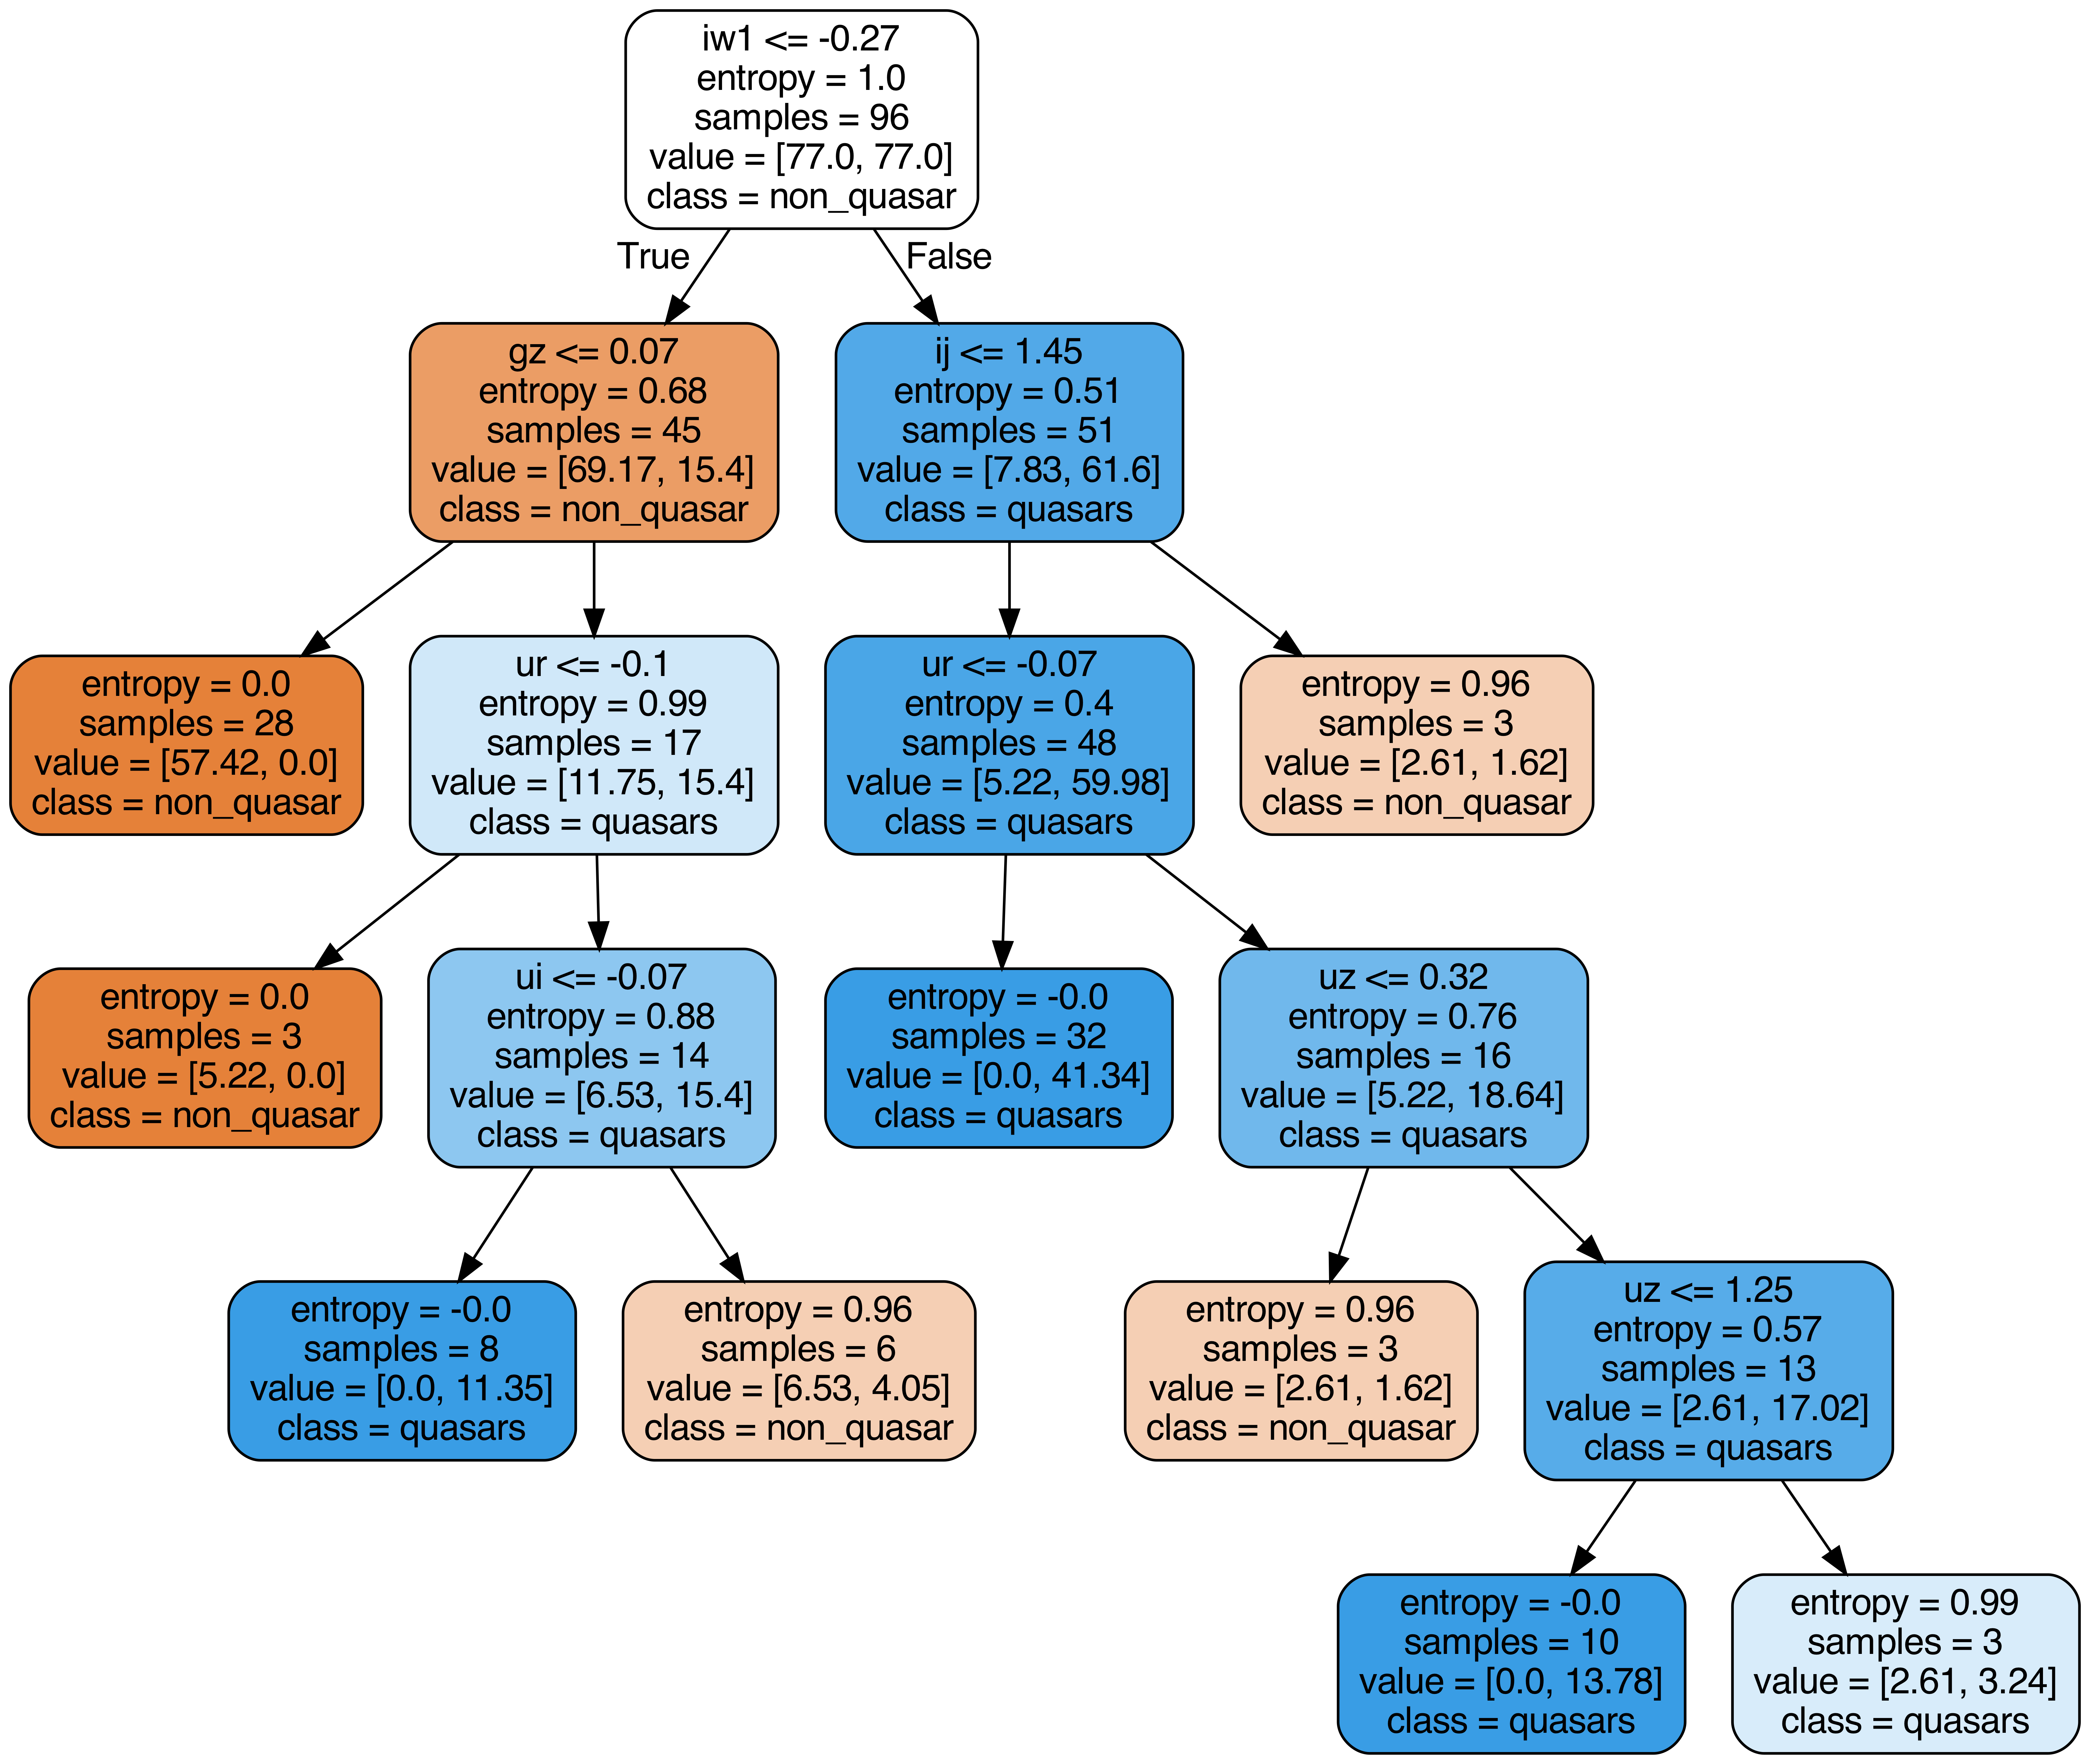

In [71]:
#picking one tree from the clf model
estimator = trainedforest.estimators_[1]

target_names = ['non_quasar','quasars']

from sklearn.tree import export_graphviz

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

- value = [67.5,67.5] describes the repartition of these objects between the two class: 67.5 for non quasars and 67.5 for quasars

# Metrics Performance

In [72]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, predictionforest))
print('F1:', metrics.f1_score(y_test,predictionforest))
print("recall:",metrics.recall_score(y_test, predictionforest))

Accuracy: 0.8431372549019608
F1: 0.8399999999999999
recall: 0.84


In [73]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predictionforest)
cf_matrix

array([[22,  4],
       [ 4, 21]])

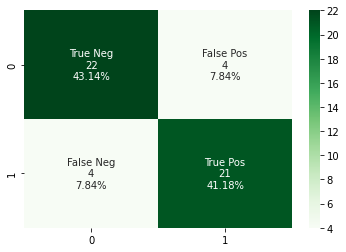

In [74]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')

plt.savefig('../figures/rfc_p_cf_matrix')

In [75]:
#generate a no skill prediction
ns_prob = [0 for _ in range(len(y_test))]
#prodict probability
clf_prob = trainedforest.predict_proba(X_test)
# keep probabilities for the positive outcome only/
clf_prob = clf_prob[:, 1]

In [76]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ns_auc = roc_auc_score(y_test, ns_prob)
lr_auc = roc_auc_score(y_test, clf_prob)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.629


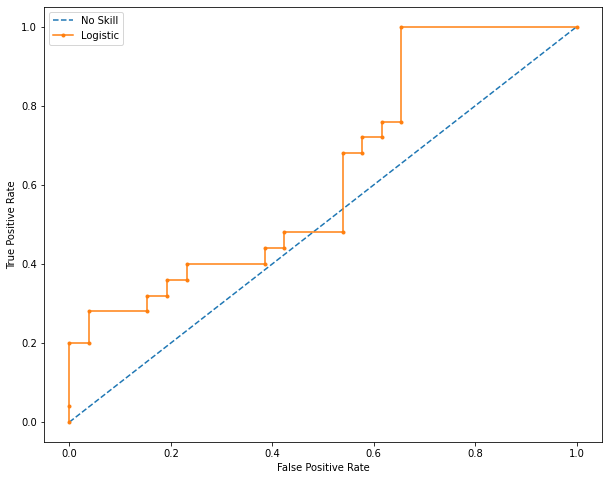

In [77]:
import matplotlib.pyplot as plt
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_prob)
lr_fpr, lr_tpr, _ = roc_curve(y_test, clf_prob)


plt.figure(figsize=(10, 8))
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.savefig('../figures/rfc_v1_rocauc.png')
# show the plot
plt.show()



In [78]:
feature_imp = pd.Series(trainedforest.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

ij            0.087719
gk            0.077501
rw1           0.061976
gw1           0.046234
gw2           0.042581
ik            0.041887
zw1           0.040044
iw1           0.036634
iw2           0.034318
rw2           0.033962
zk            0.032717
gz            0.031726
zj            0.030564
uk            0.026932
rz            0.024886
gi            0.024828
ug            0.023052
jw2           0.022779
zw2           0.022772
uw1           0.022566
w1w2          0.022298
iz            0.020982
petroR50_r    0.019948
ur            0.019128
ri            0.018817
uw2           0.018782
uj            0.018552
jw1           0.017436
uz            0.015281
ui            0.015086
kw2           0.012434
gr            0.012415
kw1           0.011892
petroR50_g    0.011274
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


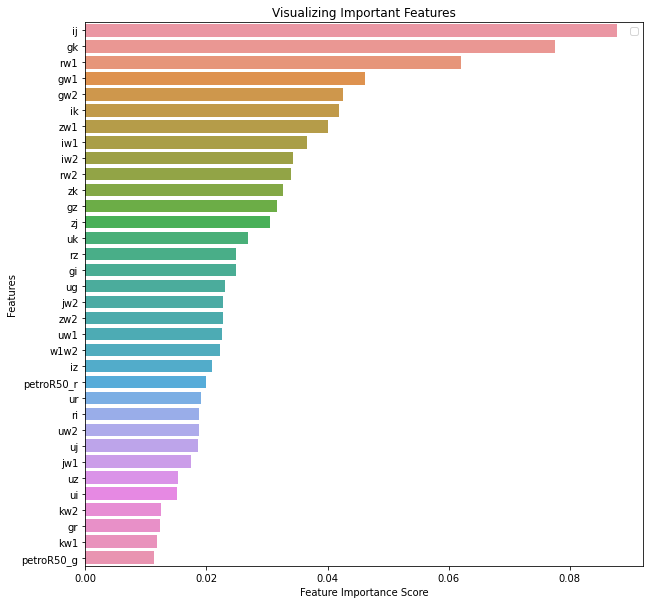

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(10, 10))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.savefig('../figures/rfc_v1_features.png')
plt.show()



When the depth of the tree = 6, the model starts to overfitting a bit. But overall, not a really big problem

In [80]:
train_scores, test_scores = list(), list()

# define the tree depths to evaluate
values = [i for i in range(1, 1000,10)]
# evaluate a decision tree for each depth
for i in values:
    # configure the model
    model = RandomForestClassifier(criterion = crit[best['criterion']], 
                                       max_depth = i, 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']])
    # fit model on the training dataset
    model.fit(X_train, y_train)
    # evaluate on the train dataset
    train_yhat = model.predict(X_train)
    train_acc = metrics.accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_yhat = model.predict(X_test)
    test_acc = metrics.accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    # summarize progress
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

NameError: name 'crit' is not defined

# Discussion

In [ ]:
df = pd.read_csv('../data/train_qso.csv')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data = df,x="ij", hue="class_bin")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data = df,x="gk", hue="class_bin")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data = df,x="gw1", hue="class_bin")